In [1]:
import numpy as np
import math as math
import random
import csv
import matplotlib.pyplot as plt

%matplotlib inline

### 8.Линейная регрессия. Задача 1.
Условие: Загрузите данные из набора Forest Fires (файл forestfires.csv) о лесных пожарах в Португалии. Задача состоит в том, чтобы с помощью линейной регрессии научиться предсказывать координату area (площадь пожаров) в виде линейной комбинации других данных. 

Чтобы работать с числовыми координатами, нечисловые координаты (month, day) нужно перевести в числовые. Для простоты можно заменить координату month на индикатор летнего сезона, а координату day не использовать вообще. По желанию можно сделать преобразование другим способом. Также добавьте координату, тождественно равную единице (вес при этой координате интерпретируется как сдвиг).

Разбейте выборку на две части в соотношении 7:3 (перемешав ее с помощью random.shuffle). По первой части постройте регрессионную модель. Примените модель ко второй части выборки и посчитайте по ней среднеквадратичную ошибку.
Для переменной area выполните преобразование $f(x) = ln(x+c)$ и постройте для нее новую регр.модель. Посчитайте среднеквадратичную ошибку для преобразованных значений. При каком значении $c$ предсказания получаются лучше всего?

При выбранном $c$ сделайте разбиение выборки в соотношении 7:3 разными способами (перемешивая каждый раз). Найдите способ оценить разброс качества от разбиения. Сильно ли меняется качество? Сделайте выводы.

In [2]:
#Cчитаем данные о пожарах и приведём их к удобному для нас формату
def get_shuffled_data():
    with open('forestfires.csv', 'r') as file:
        main_data = list(csv.reader(file))
    area = []
    data = main_data[1:]
    N = len(data)
    for i in range(N):
        #отбросим день
        data[i].pop(3)
        #координата, тождественно равная единице
        data[i].append(1.0)

    random.shuffle(data)    

    for i in range(N):
        #введем индикатор летнего сезона
        data[i][2] = 1.0 if data[i][2] in ['jun', 'jul', 'aug'] else 0.0
        data[i] = [float(number) for number in data[i]]
        area.append(data[i][-2])
        del (data[i][-2])
       
    return data, area

In [3]:
data, area = get_shuffled_data()
N = len(data)
#print(N)

###  Регрессионная модель. Теоретическое обоснование.

В файле forestfires.csv дано $N$ векторов $X_1,\dots, X_N$, имеющих $K = 13$
координат.

Рассмотрим вектор $X_i = (X_i^{1}, X_i^{2},\dots,X_i^{K})$ дающий информацию о конкретном пожаре. Будем считать, что $\forall i\in\{1,\dots,N\}$ мы измерили только координату $X_i^{K}$ (площадь пожара - area), а остальные данные $X_i^{1}, X_i^{2},\dots,X_i^{K-1}$ нам известны. Тогда area можно представить как линейную комбинацию остальных данных: 

$$\forall i\in\{1,\dots,N\} \ \ X_i^{K} = \theta_1X_i^{1} + \theta_2X_i^{2}+\dots+\theta_{K-1}X_i^{K-1}.$$
Оценим параметры $\theta = (\theta_1,\dots,\theta_{K-1})^T$. 

$$\hat \theta=(Z^TZ)^{-1}Z^T X,$$

где $X$ - данные о площадях пожаров, $Z$ - остальные данные.

Оценка для area (известны первые $K - 1 = 12$ координат каждого вектора) равна: $ \hat{A} = Z\theta. $ 

In [4]:
#Разделим данные в отношении 7:3 и построим 
#регрессионную модель по первой части выборки
data_1 = data[:N*7//10]
data_2 = data[N*7//10+1:]
area_1 = area[:N*7//10]
area_2 = area[N*7//10+1:]

In [5]:
#функция вычисления оценки
def estimate(z, x):    
    Z = np.array(z)
    X = np.array(x)
    Z_T = Z.T
    theta = np.linalg.inv(Z_T @ Z) @ Z_T @ X.T
    return theta

In [6]:
#функция вычисления ошибки
def error(z, x, theta):
    Z = np.array(z)
    X = np.array(x)
    
    alpha = (np.array(X.T - Z @ theta))**2
    return math.sqrt(alpha.sum()/(len(x) - 12))

Посчитаем среднеквадратичную ошибку $\hat{\sigma} = \frac{||X-Z\hat{\theta}||^2}{n-k}$ по второй части выборки.

In [7]:
theta_1 = estimate(data_1, area_1)
err_1 = error(data_2, area_2, theta_1)
print("Среднеквадратичная ошибка: ", err_1)

Среднеквадратичная ошибка:  32.730541756014794


Сделаем для area преобразование $f(x) = ln(x + c)$ и построим для нее новую регрессионную модель. Посчитаем среднеквадратичную ошибку для преобразованных значений. Найдем $c$, при котором среднеквадратичное отклонение минимально.

In [8]:
def estimate_2(z, x, c):    
    Z = np.array(z)
    X = np.array(x)
    X = np.log(X + c)
    Z_T = Z.T
    
    theta = np.linalg.inv(Z_T @ Z) @ Z_T @ X.T
    return theta

In [9]:
def error_2(z, x, theta):
    Z = np.array(z)
    X = np.array(x)
    
    alpha = (np.array(X.T - np.exp(Z @ theta) + c))**2
    return math.sqrt(alpha.sum() / (len(x) - 12))

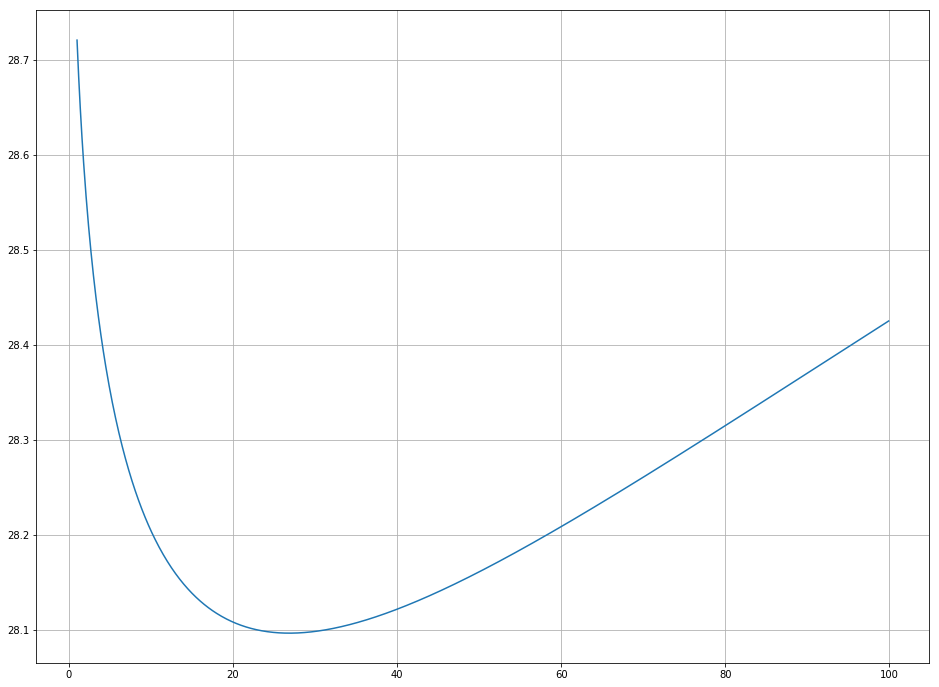

Минимальная ошибка:  28.09630224983795
c:  26.900000000000023


In [10]:
err = []

min_err = np.inf
for c in np.arange(1, 100, 0.1):
    theta_2 = estimate_2(data_1, area_1, c)
    err.append(error_2(data_2, area_2, theta_2))
    if error_2(data_2, area_2, theta_2) < min_err:
        min_err = error_2(data_2, area_2, theta_2)
        min_c = c
 
plt.figure(figsize = (16, 12))
plt.plot(np.arange(1, 100, 0.1), err)
plt.grid()
plt.show()

print("Минимальная ошибка: ", min_err)
print("c: ", min_c)

Разобьём выборку в соотношении 7:3 разными способами и найдем ошибки при полученном выше коэффициенте $c$.

In [11]:
for i in range(40):
    data, area = get_shuffled_data()
    data_1 = data[:N*7//10]
    data_2 = data[N*7//10+1:]
    area_1 = area[:N*7//10]
    area_2 = area[N*7//10+1:]
    theta_3 = estimate_2(data_1, area_1, min_c)
    err = error_2(data_2, area_2, theta_3)
    print(err)

85.025141236851
106.25731424838564
106.9057768714921
80.05624186693143
84.57832458221742
87.97017584755108
127.76706561358888
83.64276791550256
143.7585923917783
127.8009448139947
111.16608736765313
110.05932431152557
82.20821304571596
83.42681535226268
88.02003141507758
87.72890633841547
84.04286449285806
145.5787823741524
128.65954248667109
83.26456829430948
107.14394462572349
84.59158061013676
84.87323712516883
75.87591345259722
145.18721519439492
149.09116410733813
105.72798161585266
88.08505668954564
105.27704739232941
105.33174674512705
110.83747549077175
106.61153237469573
81.28593220156927
80.92122436698071
85.30687178316879
89.30948608283585
80.71336787243409
143.85611458382462
129.52166652323868
85.9595521480829


# Вывод:

Ошибка, полученная при преобразовании $f(x)=ln(x+c)$ близка к ошибке на исходных непреобразованных данных.
Видим, что в любом случае среднеквадратичное отклонение велико. К тому же, среднеквадратичное отклонение очень сильно зависит от способа разбиения, следовательно, линейную регрессию не следует применять в данном случае.